In [ ]:
# Установка rdkit
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 56.9 MB/s eta 0:00:00


In [ ]:
# Установка py3Dmol
!pip install py3Dmol

In [ ]:
# Импорт пакетов
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import py3Dmol


In [ ]:
# импорт Chem
from rdkit import Chem

## Данные из статьи

In [ ]:
# выгружаем данные из .csv файла (smiles и аквтивность)
df_smiles_activity = pd.read_csv('potok.csv')
df_smiles_activity

,№,smiles,activity
0,1,NCCC(OCCN(CCCCCCCC)CCOC(CCN)=O)=O,0.100000
1,2,NCCC(OCCN(CCCCCCCCCCCC)CCOC(CCN)=O)=O,0.200000
2,3,CCCCCCCCCCCCN(CCOC(CCCN)=O)CCOC(CCCN)=O,0.001000
3,4,NCCCC(OCCN(CCCCCCCC)CCOC(CCCN)=O)=O,0.001000
4,5,NC(C(OCCN(CCOC(C(CC1=CC=CC=C1)CN)=O)CCCCCCCC)=...,0.100000
...,...,...,...
84,85,NCCC(OCCN(CCCCCCCC)CCOC(CCN)=O)=O,0.000100
85,86,NCC(CC1=CC=CC=C1)C(OCCN(CCCCCCCC)CCOC(C(CC2=CC...,0.010000
86,87,NCC(CC1=CC(C=CN2)=C2C=C1)C(OCCN(CCCCCCCC)CCOC(...,0.010000
87,88,NCC(CC1=CC=C(O)C=C1)C(OCCN(CCCCCCCC)CCOC(C(CC2...,0.010000


In [ ]:
df = pd.read_csv('potok.csv')
df.head()

,№,smiles,activity
0,1,NCCC(OCCN(CCCCCCCC)CCOC(CCN)=O)=O,0.100
1,2,NCCC(OCCN(CCCCCCCCCCCC)CCOC(CCN)=O)=O,0.200
2,3,CCCCCCCCCCCCN(CCOC(CCCN)=O)CCOC(CCCN)=O,0.001
3,4,NCCCC(OCCN(CCCCCCCC)CCOC(CCCN)=O)=O,0.001
4,5,NC(C(OCCN(CCOC(C(CC1=CC=CC=C1)CN)=O)CCCCCCCC)=...,0.100


In [ ]:
df.columns

Index(['№', 'smiles', 'activity'], dtype='object')

In [ ]:
df = df[["smiles", "activity"]]
df.head()

,smiles,activity
0,NCCC(OCCN(CCCCCCCC)CCOC(CCN)=O)=O,0.100
1,NCCC(OCCN(CCCCCCCCCCCC)CCOC(CCN)=O)=O,0.200
2,CCCCCCCCCCCCN(CCOC(CCCN)=O)CCOC(CCCN)=O,0.001
3,NCCCC(OCCN(CCCCCCCC)CCOC(CCCN)=O)=O,0.001
4,NC(C(OCCN(CCOC(C(CC1=CC=CC=C1)CN)=O)CCCCCCCC)=...,0.100


In [ ]:
df["activity"] = pd.to_numeric(df["activity"], errors="coerce")

In [ ]:
df["activity"].unique()[:20]

array([0.1    , 0.2    , 0.001  , 0.00156, 0.013  , 0.002  , 0.128  ,
       0.064  , 0.016  , 0.004  , 0.008  , 0.032  , 0.15   , 0.072  ,
       0.3    , 0.025  , 0.5    , 0.204  , 0.108  , 0.028  ])

In [ ]:
df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
df = df[df["mol"].notnull()]

In [ ]:
df["smiles"].head()

,smiles
0,NCCC(OCCN(CCCCCCCC)CCOC(CCN)=O)=O
1,NCCC(OCCN(CCCCCCCCCCCC)CCOC(CCN)=O)=O
2,CCCCCCCCCCCCN(CCOC(CCCN)=O)CCOC(CCCN)=O
3,NCCCC(OCCN(CCCCCCCC)CCOC(CCCN)=O)=O
4,NC(C(OCCN(CCOC(C(CC1=CC=CC=C1)CN)=O)CCCCCCCC)=...


In [ ]:
df["logACT"] = np.log10(df["activity"])

print("Final size:", len(df))
print(df.columns)

df[["smiles", "activity", "logACT"]].head()

Final size: 89
Index(['smiles', 'activity', 'mol', 'logACT'], dtype='object')


,smiles,activity,logACT
0,NCCC(OCCN(CCCCCCCC)CCOC(CCN)=O)=O,0.100,-1.00000
1,NCCC(OCCN(CCCCCCCCCCCC)CCOC(CCN)=O)=O,0.200,-0.69897
2,CCCCCCCCCCCCN(CCOC(CCCN)=O)CCOC(CCCN)=O,0.001,-3.00000
3,NCCCC(OCCN(CCCCCCCC)CCOC(CCCN)=O)=O,0.001,-3.00000
4,NC(C(OCCN(CCOC(C(CC1=CC=CC=C1)CN)=O)CCCCCCCC)=...,0.100,-1.00000


In [ ]:
import numpy as np
from rdkit.Chem import AllChem, DataStructs
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def morgan_fp_array(mol, radius=2, n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

X = np.vstack([morgan_fp_array(m) for m in df["mol"]])
y = df["logACT"].to_numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (89, 2048)
y shape: (89,)


[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerator
[13:32:22] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
# === CV setup: схема повторяемой 5-fold кросс-валидации (честная оценка на малом датасете) ===
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# === Storage: сюда будем складывать метрики по фолдам ===
maes, rmses, r2s = [], [], []

# === Tolerances: пороги "в пределах 2x/4x MIC" в лог-шкале ===
tol2 = np.log10(2)
tol4 = np.log10(4)
acc2, acc4 = [], []

# === CV loop: многократно делим данные на train/test, учим и считаем метрики ===
for train_idx, test_idx in rkf.split(X):
    # split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # train model: Ridge regression (линейная модель с регуляризацией)
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)

    # predict on test fold
    pred = model.predict(X_test)

    # metrics
    maes.append(mean_absolute_error(y_test, pred))
    rmses.append(np.sqrt(mean_squared_error(y_test, pred)))
    r2s.append(r2_score(y_test, pred))

    # within 2x / 4x in MIC terms (через ошибку в log10)
    acc2.append(np.mean(np.abs(pred - y_test) <= tol2))
    acc4.append(np.mean(np.abs(pred - y_test) <= tol4))

# === Final report: средние метрики по всем фолдам ===
print("CV MAE:", np.mean(maes))
print("CV RMSE:", np.mean(rmses))
print("CV R2:", np.mean(r2s))
print("Within 2x:", np.mean(acc2))
print("Within 4x:", np.mean(acc4))



CV MAE: 0.5822688243798583
CV RMSE: 0.7607991536772625
CV R2: 0.16976625295274805
Within 2x: 0.3458823529411765
Within 4x: 0.6172549019607844


In [ ]:
mean_y = np.mean(y)

mae_baseline = np.mean(np.abs(y - mean_y))
print("Baseline MAE:", mae_baseline)


Baseline MAE: 0.7070415402013275


#ТАКАЯ ОШИБКА ПОКАЗЫВАЕТ ЧТО МОРГАНС ФИНГЕРПРИНТ ОТНОСИТЕЛЬНО ДЕРЬМОВО ИСПОЛЬЗОВАТЬ НА АМП!

In [ ]:
df = df.drop_duplicates(subset="smiles").reset_index(drop=True)

In [ ]:
df = df[df["activity"] > 0]

In [ ]:
# Выбираем нужные Дескрипторы для наших соединений и назначим для них переменные:

# Дескрипторы по Липински
mw_ = round(Descriptors.MolWt(mol_), 3)
logp_ = round(Descriptors.MolLogP(mol_), 3)
h_donor = Descriptors.NumHDonors(mol_)
h_acceptor = Descriptors.NumHAcceptors(mol_)

# Дескрипторы специфике соединений
heteroatoms = Descriptors.NumHeteroatoms(mol_)
rotbonds = Descriptors.NumRotatableBonds(mol_)

AllChem.ComputeGasteigerCharges(mol_)
gasteigerch = round(mol_.GetAtomWithIdx(0).GetDoubleProp('_GasteigerCharge'), 3)
minparcharge = Descriptors.MinPartialCharge(mol_)
# тут могут быть еще дескрипторы

NameError: name 'mol_' is not defined

In [ ]:
# 'MolWt' , 'NumAliphaticCarbocycles' , 'NumAliphaticHeterocycles', 'NumAliphaticRings',
# 'NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,
# 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles',
# 'NumSaturatedHeterocycles'
# 'NumHAcceptors', 'MolWt', 'NumHeteroatoms', 'NumHAcceptors', 'NumHDonors', 'NumAromaticRings'

In [ ]:
# Составляем функцию расчета дескрипторов
def descriptors_calc(smiles_,
                     ):

  mols = [Chem.MolFromSmiles(i) for i in smiles_] #превращаем smiles в молекулы
  # создаем списки для дескрипторов
  mw_descriptor = []
  logp_descriptor = []
  #h_donordescriptor = []
  h_acceptordescriptor = []
  heteroatomsdescriptor = []
  rotbondsdescriptor = []
  #gasteigerchdescriptor = []
  minparchargedescriptor = []
  # вы можете отключать не значащие дескрипторы и/или добавлять новые
  for mol_ in mols:
    # Добавить водород
    mol_ = Chem.AddHs(mol_)
    # вычисляем дескрипторы
    # Дескрипторы по Липински
    mw_ = round(Descriptors.MolWt(mol_), 3)
    logp_ = round(Descriptors.MolLogP(mol_), 3)
    #h_donor = Descriptors.NumHDonors(mol_)
    h_acceptor = Descriptors.NumHAcceptors(mol_)

    # Дескрипторы специфике соединений
    heteroatoms = Descriptors.NumHeteroatoms(mol_)
    rotbonds = Descriptors.NumRotatableBonds(mol_)

    #AllChem.ComputeGasteigerCharges(mol_)
    #gasteigerch = round(mol_.GetAtomWithIdx(0).GetDoubleProp('_GasteigerCharge'), 3)
    minparcharge = - round(Descriptors.MinPartialCharge(mol_), 4) #заряд инвертируем для простоты нормализации

    # Добавляем полученные значения в списки
    mw_descriptor.append(mw_)
    logp_descriptor.append(logp_)
    #h_donordescriptor.append(h_donor)
    h_acceptordescriptor.append(h_acceptor)
    heteroatomsdescriptor.append(heteroatoms)
    rotbondsdescriptor.append(rotbonds)
    #gasteigerchdescriptor.append(gasteigerch)
    minparchargedescriptor.append(minparcharge)

    # можно объеденить списки в кортеж или вернуть все списки, но
    # будьте внимательны, чтобы число совпадало
    # так же можно сразу вернуть df фаил



  #укажите используемые дескрипторы и дополните функцию если они в какието отсутсвуют
  df_descriptors = pd.DataFrame(list(zip(mw_descriptor, logp_descriptor,
                      h_acceptordescriptor, heteroatomsdescriptor, rotbondsdescriptor,
                       minparchargedescriptor)), columns = ('MolWt', 'MolLogP', 'NumHAcceptors', 'NumHeteroatoms', 'NumRotatableBonds', 'InvMinPartialCharge'))

  return df_descriptors


In [ ]:
df_descriptors = descriptors_calc(df_smiles_activity['smiles'])
df_descriptors # выведем датасет

,MolWt,MolLogP,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,InvMinPartialCharge
0,359.511,1.433,7,7,20,0.4643
1,415.619,2.993,7,7,24,0.4643
2,443.673,3.774,7,7,26,0.4643
3,387.565,2.213,7,7,22,0.4643
4,525.734,4.123,7,7,23,0.4641
...,...,...,...,...,...,...
84,359.511,1.433,7,7,20,0.4643
85,539.761,4.371,7,7,24,0.4641
86,617.835,5.333,7,9,24,0.4641
87,571.759,3.782,9,9,26,0.5080


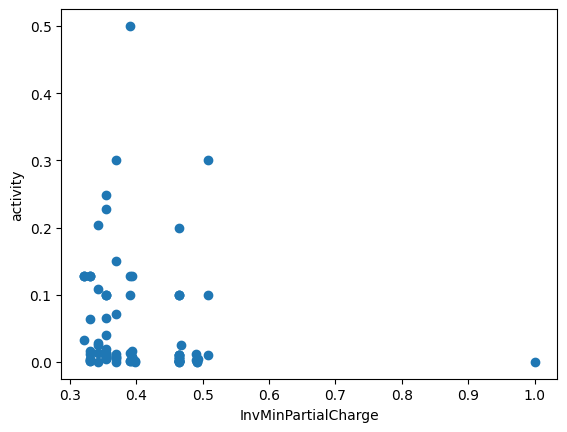

In [ ]:
# Построим график зависимости выбранного дескриптора и целевой величины
plt.scatter(df_descriptors['InvMinPartialCharge'], df_smiles_activity['activity'])
plt.xlabel('InvMinPartialCharge')
plt.ylabel('activity')
plt.show()

## Построим график кореляций

In [ ]:
desc_name = ('MolWt', 'MolLogP', 'NumHAcceptors', 'NumHeteroatoms', 'NumRotatableBonds', 'InvMinPartialCharge')

In [ ]:
# сохраняем фаил в .csv
filedesc_name = ''
df_descriptors.to_csv(f'{filedesc_name}.csv')

In [ ]:
# сделаем это с помощью лямбда функции
for name in desc_name:
  max_data = df_descriptors[name].max()
  df_descriptors[name] = df_descriptors[name].apply(lambda x:round(x/max_data, 4))

df_descriptors_norm = df_descriptors
df_descriptors_norm

,MolWt,MolLogP,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,InvMinPartialCharge
0,0.1293,0.1532,0.2000,0.1111,0.1460,0.4643
1,0.1495,0.3200,0.2000,0.1111,0.1752,0.4643
2,0.1596,0.4035,0.2000,0.1111,0.1898,0.4643
3,0.1394,0.2366,0.2000,0.1111,0.1606,0.4643
4,0.1891,0.4408,0.2000,0.1111,0.1679,0.4641
...,...,...,...,...,...,...
84,0.1293,0.1532,0.2000,0.1111,0.1460,0.4643
85,0.1941,0.4673,0.2000,0.1111,0.1752,0.4641
86,0.2222,0.5701,0.2000,0.1429,0.1752,0.4641
87,0.2056,0.4043,0.2571,0.1429,0.1898,0.5080


In [ ]:
# Затем нужно добавить активность в дата сет
df_descriptors_norm['activity'] = df_smiles_activity['activity']
df_descriptors_full = df_descriptors_norm
df_descriptors_full

,MolWt,MolLogP,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,InvMinPartialCharge,activity
0,0.1293,0.1532,0.2000,0.1111,0.1460,0.4643,0.100000
1,0.1495,0.3200,0.2000,0.1111,0.1752,0.4643,0.200000
2,0.1596,0.4035,0.2000,0.1111,0.1898,0.4643,0.001000
3,0.1394,0.2366,0.2000,0.1111,0.1606,0.4643,0.001000
4,0.1891,0.4408,0.2000,0.1111,0.1679,0.4641,0.100000
...,...,...,...,...,...,...,...
84,0.1293,0.1532,0.2000,0.1111,0.1460,0.4643,0.000100
85,0.1941,0.4673,0.2000,0.1111,0.1752,0.4641,0.010000
86,0.2222,0.5701,0.2000,0.1429,0.1752,0.4641,0.010000
87,0.2056,0.4043,0.2571,0.1429,0.1898,0.5080,0.010000


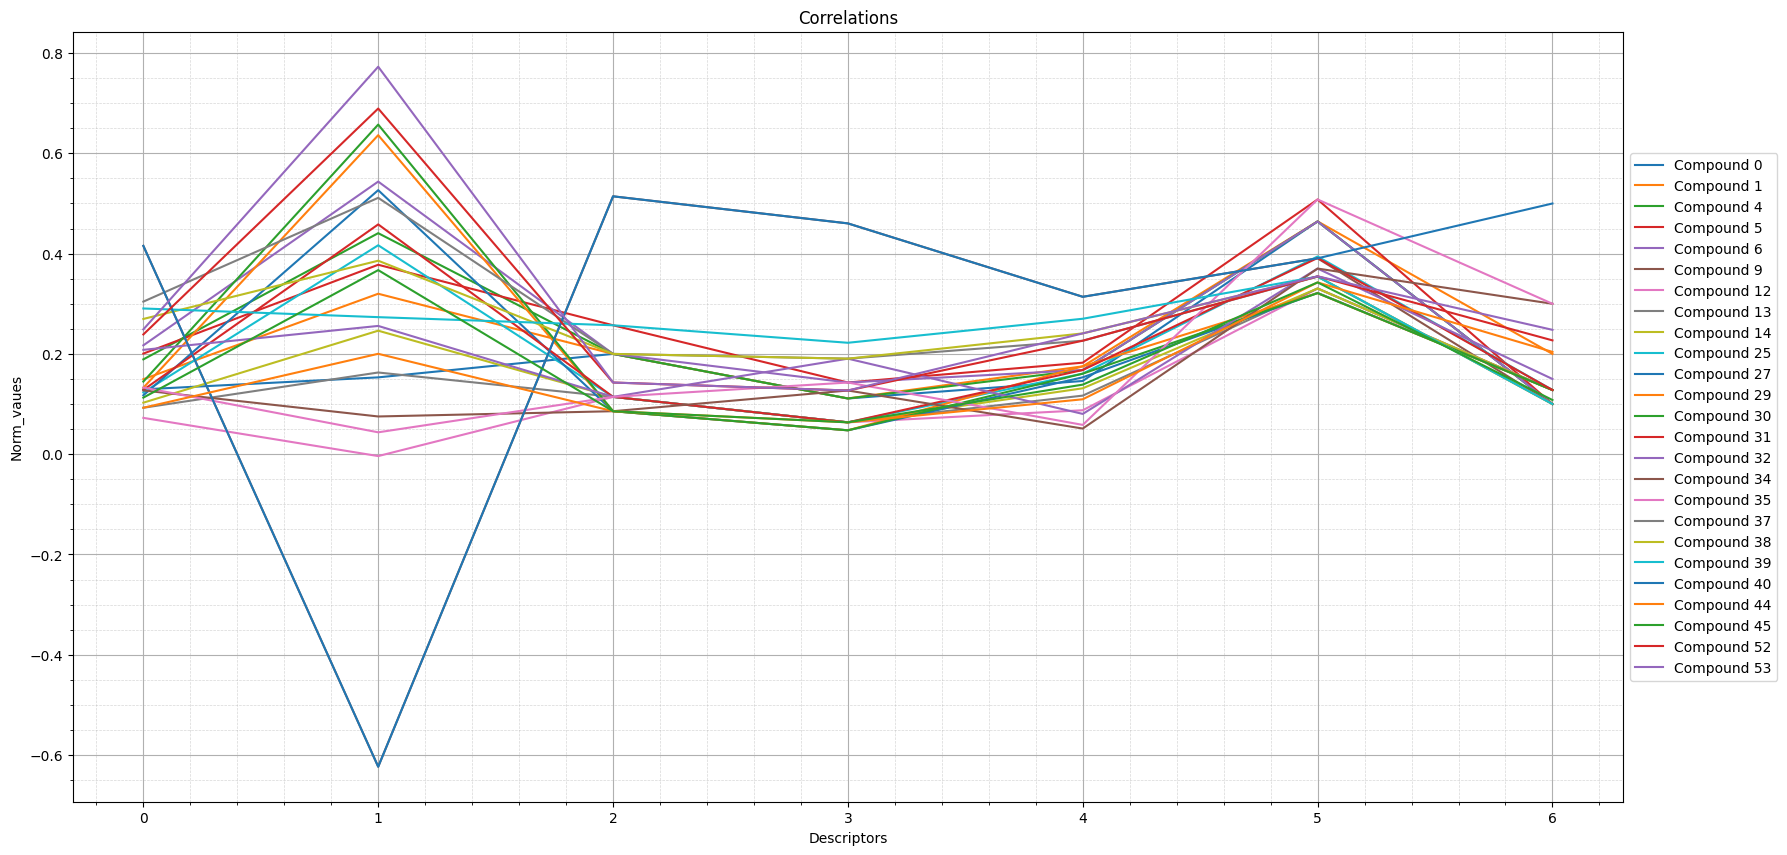

In [ ]:
# Строим график где У это величина дескриптора, а Х это номер дескриптора
X_data = [i for i in range(0, len(desc_name) + 1)]

row_lists = df_descriptors_full.values.tolist() #преобразуем строки в списки

#учтем только соединения с высокой активностью
activity_90_list = []
index_list = []
for rows_ in row_lists:
  if rows_ [6] >= 0.1:
    index_ = row_lists.index(rows_)
    activity_90_list.append(rows_)
    index_list.append(index_)

Y_data = activity_90_list

#создадим переменную графика и укажем его размер
fig, ax = plt.subplots(figsize=(20, 10))

# Построим график каждой линии
for i, line in enumerate(Y_data):
    ax.plot(X_data, line, label=f'Compound {index_list[i]}')

#Добавим сетку
ax.grid(True)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='--', linewidth='0.5', alpha=0.5)

# Добавим подпиччи
ax.set_xlabel('Descriptors')
ax.set_ylabel('Norm_vaues')
ax.set_title('Correlations')

# Расположение легенды
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Функция расчета Т критерия

In [ ]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [ ]:
# Функция расчета отпечатков
def morgan_fpts(data, similaty_to_):
    mol = Chem.MolFromSmiles(data)
    fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)

    mol_to = Chem.MolFromSmiles(similaty_to_)
    similaty_to_fp = AllChem.GetMorganFingerprintAsBitVect(mol_to,2,2048)

    similarity_T_ = DataStructs.TanimotoSimilarity(fpts, similaty_to_fp)

    return similarity_T_

In [ ]:
reference_compound_name = 'compound_8' #

In [ ]:
# вещество сравнения берем смайлс и преобразовывваем в каноничный
smiles_reference_ = 'OP(OC1=C2C=C(C3=CC(F)=CC=C3)C=C1)(CC=C2)=O'
mol1 = Chem.MolFromSmiles(smiles_reference_)
smiles_reference_cannon = Chem.MolToSmiles(mol1)
similaty_to_ = smiles_reference_cannon

In [ ]:
# Лист с исследуемыми веществами
data_list = df_smiles_activity['smiles']

In [ ]:
# создаем лист для данных сравнения и расчитываем сродство по отпечаткам
similarity_T_list = []

for data in data_list:

  similarity_T_ = round(morgan_fpts(data, similaty_to_), 4)

  similarity_T_list.append(similarity_T_ )

[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerator
[13:34:05] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
#готовим данные к сохранению
data_list
path_to_similarity = '/content/' + f'morfps_sim_file_{reference_compound_name}_.txt'

In [ ]:
#функция сохранения
def similarity_T_filecreator(path_to_similarity, reference_compound_name,
                             data_list, similarity_T_list):

  with open(path_to_similarity, 'w') as sTf:

    header = f'Tanimoto similarity to {reference_compound_name} from {len(similarity_T_list)} compounds' + '\n' + '\n'

    sTf.write(header)

    info_header = 'smiles, T similarity' + '\n'
    sTf.write(info_header)

    summary_data_list = []

    for i in range(0, len(similarity_T_list)):

      data_  = data_list[i], similarity_T_list[i]
      summary_data_list.append(data_)

    for data_t in summary_data_list:
      data_str = str(data_t)
      data_prep = data_str[1:-1] + '\n'

      sTf.write(data_prep)



In [ ]:
similarity_T_filecreator(path_to_similarity, reference_compound_name,
                             data_list, similarity_T_list)

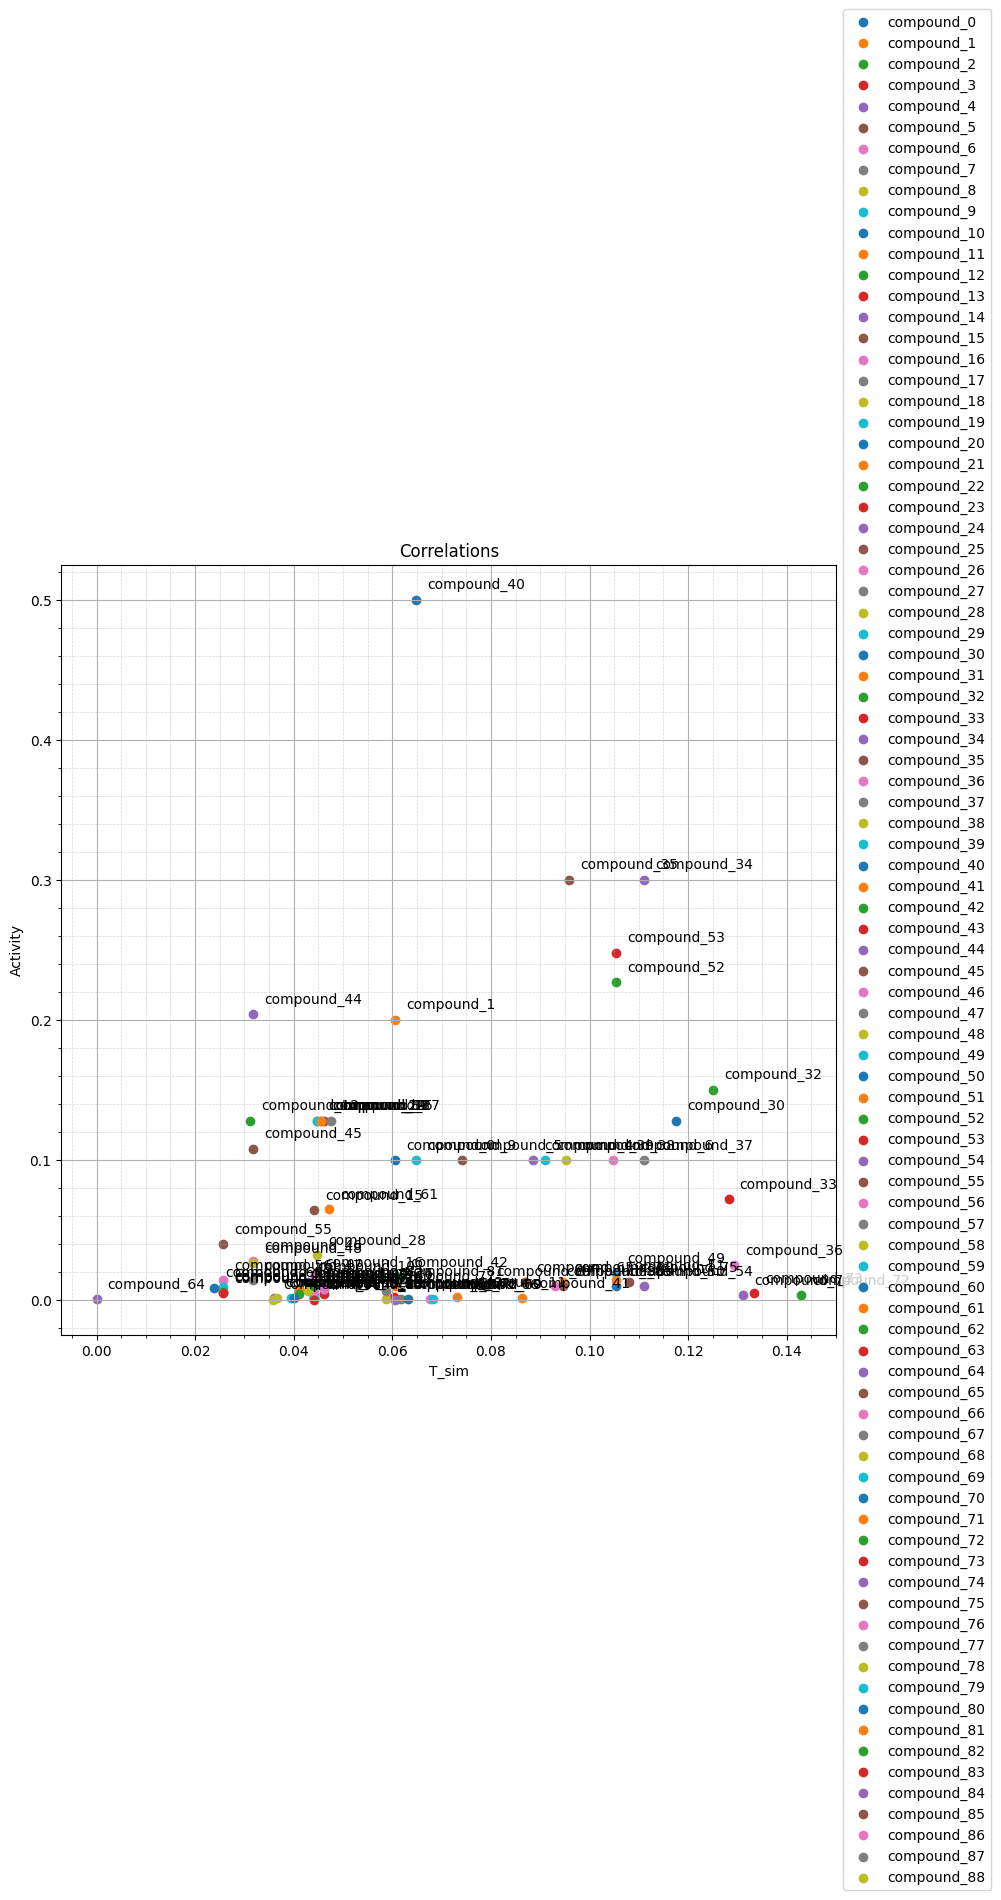

In [ ]:
# можно сравнить активность и Т-схожесть
X_data_ = similarity_T_list
Y_data_ = df_smiles_activity['activity']
labels = [f'compound_{i}' for i in range(0, len(Y_data_))]

fig, ax = plt.subplots(figsize=(10, 10))

# Построим график каждой линии
for i in range(0, len(Y_data_)):
  ax.scatter(X_data_[i], Y_data_[i], label= f'compound_{i}')

for i, txt in enumerate(labels):
    ax.annotate(txt, (X_data_[i], Y_data_[i]), xytext=(8, 8), textcoords='offset points')

#Добавим сетку
ax.grid(True)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='--', linewidth='0.5', alpha=0.5)

# Добавим подпиччи
ax.set_xlabel('T_sim')
ax.set_ylabel('Activity')
ax.set_title('Correlations')

# Расположение легенды
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
# Что можно сказать по информации из графика?

## Поиск отпечатков которые сильнее влияют на активность

In [ ]:
# создадим функцию для создания массива из отпечатков
def morgan_fps_massive(data):

    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)

    return np.array(Morgan_fpts)


In [ ]:
fps_array = morgan_fps_massive(df_smiles_activity['smiles'])
fps_array.shape

[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerator
[13:36:31] DEPRECATION WARNING: please use MorganGenerat

(89, 2048)

In [ ]:
fps_array_data = pd.DataFrame(fps_array,columns=['{}'.format(i) for i in range(fps_array.shape[1])])
fps_array_data

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fps_array_data = fps_array_data.loc[:, (fps_array_data != 0).any(axis=0)]
data_nozero = fps_array_data
data_nozero

,1,13,26,27,33,38,41,54,56,79,...,1990,1991,2000,2002,2004,2006,2016,2027,2031,2032
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
non_zero_columns = []
for index_ in range(0, len(data_nozero)):

  row_index = index_
  columns_new = [int(col) for col in data_nozero.columns if data_nozero.loc[row_index, col] != 0]
  non_zero_columns.append(columns_new)


In [ ]:
len(df_smiles_activity['activity'])

89

/tmp/ipython-input-4274080592.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


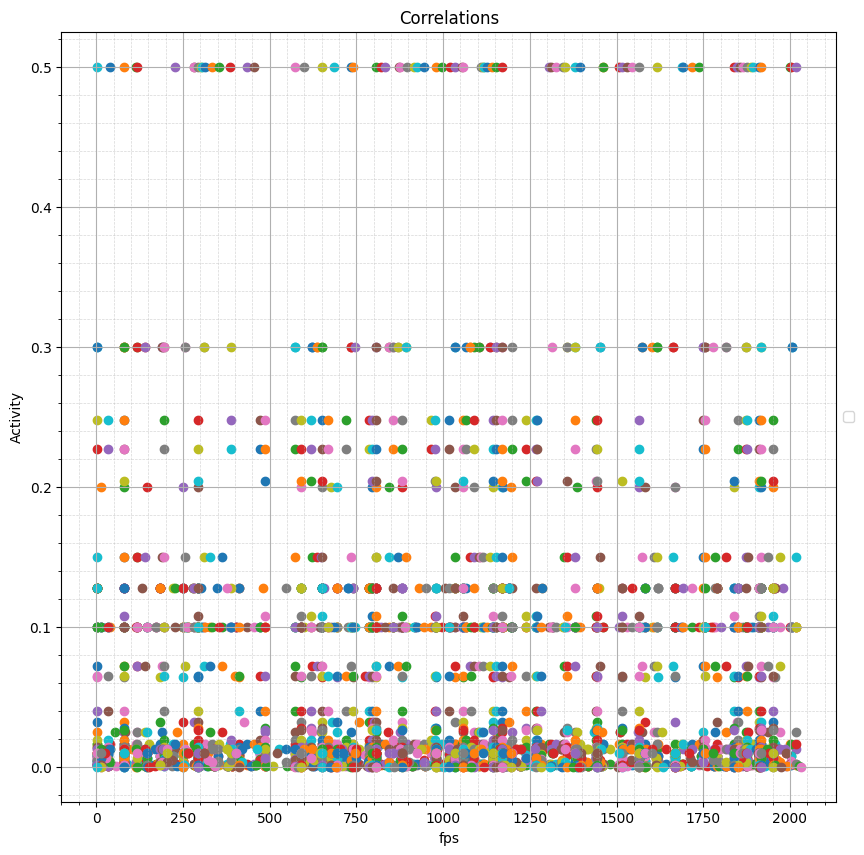

In [ ]:
# Re-generate fps_array_data and non_zero_columns to ensure they are defined and consistent.
# This assumes fps_array (Variable #11) is correctly defined with 89 rows.
fps_array_data = pd.DataFrame(fps_array,columns=['{}'.format(i) for i in range(fps_array.shape[1])])
data_nozero = fps_array_data.loc[:, (fps_array_data != 0).any(axis=0)]

non_zero_columns = []
for index_ in range(0, len(data_nozero)):
  row_index = index_
  columns_new = [int(col) for col in data_nozero.columns if data_nozero.loc[row_index, col] != 0]
  non_zero_columns.append(columns_new)

X_data_fp = non_zero_columns
Y_data_fp = df_smiles_activity['activity']
Z_data_fp = [range(0, len(Y_data_fp))]

fig, ax = plt.subplots(figsize=(10, 10))


for i in range(0, len(Y_data_fp)):
  for j in range(0, len(X_data_fp[i])):

    ax.scatter(X_data_fp[i][j], Y_data_fp[i])




#Добавим сетку
ax.grid(True)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='--', linewidth='0.5', alpha=0.5)

# Добавим подпиччи
ax.set_xlabel('fps')
ax.set_ylabel('Activity')
ax.set_title('Correlations')

# Расположение легенды
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## На доработку
